In [1]:
# Import Statements

import numpy as np
import tensorflow as tf
import pandas as pd
import html
import re
import string
from fncbaseline.utils import dataset, generate_test_splits, score
from nltk.corpus import stopwords
from gensim.summarization import summarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the dataset
train_dataset = dataset.DataSet()
test_dataset = dataset.DataSet('test')

Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset
Total stances: 25413
Total bodies: 904


In [3]:
# Global Variables

global_map = dict()
SUMMARY_LEN = 100

#Variables for Preprocessing
do_summary = False
head_stop,head_summary = True, False
body_stop,body_summary = True, False

# Embedding Dimension
EMBEDDING_DIM = 300

# Head and body max
max_head = 30
max_body = 500


In [4]:
# Function to Preprocess the data

def preprocess(text,stop,do_summ):
    g_text = text
    if g_text in global_map :
        return global_map[g_text]
    
    if do_summ:
        temp = re.sub(r'[.]+',"\n",text)
        if len(temp.split()) > SUMMARY_LEN:
            text = summarize(temp,word_count = SUMMARY_LEN)
              
    text = html.unescape(text)
    text = text.replace("\\n"," ")
    text = text.replace("_NEG","")
    text = text.replace("_NEGFIRST", "")
    text = re.sub(r"#", "", text)
    text = re.sub(r"\*", "", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r",", "", text)
    text = re.sub(r"!", " !", text)
    text = re.sub(r"\(", "", text)
    text = re.sub(r"\)", "", text)
    text = re.sub(r"\?", " ?", text)
    text = re.sub(r'[^\x00-\x7F]',' ', text)
    text = re.sub(r'[^\w\s]',' ',text)
    text = re.sub("\d+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.rstrip(',|.|;|:|\'|\"')
    text = text.lstrip('\'|\"')
    if stop:
        temp = remove_stopwords(text.strip().lower())
        global_map[g_text] = temp
    else:
        temp = (text.strip().lower())
        global_map[g_text] = temp
    return global_map[g_text]

def remove_stopwords(text):
    temp = stopwords.words('english')
    split_text = \
    [word for word in text.split()
        if word not in temp]
    return " ".join(split_text)

def create_total_text(dataset,isStance,total_text):
    if isStance:
        for stance in dataset.stances:
            total_text.append(preprocess(stance['Headline'],head_stop,head_summary))
    else:
        for article_id in dataset.articles:
            total_text.append(preprocess(dataset.articles[article_id],body_stop,body_summary))

In [5]:
# Total Dataset 
total_text = list()
create_total_text(train_dataset,True,total_text)
print(len(total_text)) #sanity check
create_total_text(train_dataset,False,total_text)
print(len(total_text)) #sanity check
create_total_text(test_dataset,True,total_text)
print(len(total_text)) #sanity check
create_total_text(test_dataset,False,total_text)
print(len(total_text)) #sanity check

49972
51655
77068
77972


In [6]:
# Fiting a tokenizer on it
t = Tokenizer()
t.fit_on_texts(total_text)
word_index = t.word_index
print(t.document_count)
vocab_size = len(t.word_counts)
print(vocab_size)

77972
28378


In [8]:
temp_name = 'embedding_matrix_w2v'
create_w2vec = False
if do_summary:
    temp_name+="_summary.npy"
else:
    temp_name+="_no_summary.npy"
if create_w2vec:
    
    w2v_DIR = "./fnc-1/GoogleNews-vectors-negative300.txt"
    embeddings_index = {}
    f = open(GLOVE_DIR)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print ('Read Word2Vec and Made Dict')

    embedding_matrix = np.zeros((vocab_size + 1, EMBEDDING_DIM))
    number_found =0
    number_not_found = 0
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            number_found+=1
        else:
            #print (word)
            number_not_found+=1

    print(number_found)
    print(number_not_found)
    np.save(temp_name,embedding_matrix)
else:
    embedding_matrix = np.load(temp_name)

In [9]:
def create_dataset(data,ids,isTest,t,max_head,max_body):
    
    from keras.utils.np_utils import to_categorical
    head = list()
    body = list()
    y = list()
    NUM_CLASSES = 4
    category_dict = {'unrelated': 0 , 'agree':1, 'disagree':2, 'discuss':3}
    for stance in data.stances:
        if(isTest):
            head.append(preprocess(stance['Headline'],head_stop,head_summary))
            body.append(preprocess(data.articles[int(stance['Body ID'])],body_stop,body_summary))
            y.append(category_dict[stance['Stance']])
            continue
        
        if stance['Body ID'] not in ids:
            continue
        
        head.append(preprocess(stance['Headline'],head_stop,head_summary))
        body.append(preprocess(data.articles[int(stance['Body ID'])],body_stop,body_summary))
        y.append(category_dict[stance['Stance']])
    
    head = t.texts_to_sequences(head)
    body = t.texts_to_sequences(body)
    head = pad_sequences(head,maxlen = max_head,padding = 'post')
    body = pad_sequences(body,maxlen = max_body,padding = 'post')
    y_cat = np.zeros((len(y),NUM_CLASSES))
    y_cat = to_categorical(y, num_classes=NUM_CLASSES)
    return head,body,y_cat

def create_labels(data):

#     Usage
#     y_train = create_labels(train_dataset)
#     y_test = create_labels(test_dataset)

    from keras.utils.np_utils import to_categorical
    category_dict = {'unrelated': 0 , 'agree':1, 'disagree':2, 'discuss':3}
    y = list()
    NUM_CLASSES = 4
    for stance in data.stances:
        y.append(category_dict[stance['Stance']])

    y_cat = np.zeros((len(y),NUM_CLASSES))
    y_cat = to_categorical(y, num_classes=NUM_CLASSES)
    return y_cat


In [10]:
(train_text,train_body,y_train) = create_dataset(train_dataset,None,True,t,max_head,max_body)
(test_text,test_body,y_test) = create_dataset(test_dataset,None,True,t,max_head,max_body)

In [12]:
#sanity check
print(len(train_text))
print(len(test_text))
print(len(train_dataset.stances))

49972
25413
49972


In [13]:
def create_hand_features(feat_fn,data,ids,isTest,name):
    head = list()
    body = list()
    for stance in data.stances:
        if(isTest):
            head.append(stance['Headline'])
            body.append(data.articles[int(stance['Body ID'])])
            continue
        
        if stance['Body ID'] not in ids:
            continue
        
        head.append(stance['Headline'])
        body.append(data.articles[int(stance['Body ID'])])
    
    
    features = feature_engineering.gen_or_load_feats(feat_fn, head ,body, './fnc-1/'+str(feat_fn.__name__)+name+'.npy')
    return features


def get_simplified_data(data):
    head = list()
    body = list()
    for stance in data.stances:
        head.append(stance['Headline'])
        body.append(data.articles[int(stance['Body ID'])])
    return (head,body)
def get_unique_head(dataset):
    
    head = list()
    for stance in dataset.stances:
        if stance['Headline'] not in head:
            head.append(stance['Headline'])
    return head

def get_unique_body(dataset):
    
    body = list()
    for i in dataset.articles.keys():
        body.append(dataset.articles[i])

    return body

def get_tf_features(train_dataset,test_dataset):
    
    train_head,train_body = get_simplified_data(train_dataset)
    test_head,test_body = get_simplified_data(test_dataset)
    
    train_unique_head = get_unique_head(train_dataset)
    train_unique_body = get_unique_body(train_dataset)
    test_unique_head = get_unique_head(test_dataset)
    test_unique_body = get_unique_body(test_dataset)
    
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    bow_vectorizer = CountVectorizer(max_features=num_words, stop_words='english')
    bow = bow_vectorizer.fit_transform(train_unique_head + train_unique_body)
    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfidf_vectorizer = TfidfVectorizer(max_features=num_words, stop_words='english').fit(train_unique_head + train_unique_body+test_unique_body+test_unique_head)
    
    train_head_features_tf = list()
    train_body_features_tf = list()
    train_cosine = list()
    head_dict = dict()
    body_dict = dict()
    
    
    for stance in train_dataset.stances:
        heading = stance['Headline']
        body = train_dataset.articles[int(stance['Body ID'])]
        if heading not in head_dict:
            head_dict[heading] = (tfreq_vectorizer.transform(bow_vectorizer.transform([heading])).toarray(),tfidf_vectorizer.transform([heading]).toarray())
        if body not in body_dict:
            body_dict[body] = (tfreq_vectorizer.transform(bow_vectorizer.transform([body])).toarray(),tfidf_vectorizer.transform([body]).toarray())
        
        train_head_features_tf.append(head_dict[heading][0])
        train_body_features_tf.append(body_dict[body][0])
        train_cosine.append(cosine_similarity(head_dict[heading][1],body_dict[body][1]))
    
    test_head_features_tf = list()
    test_body_features_tf = list()
    test_cosine = list()
    head_dict = dict()
    body_dict = dict()
    for stance in test_dataset.stances:
        heading = stance['Headline']
        body = test_dataset.articles[int(stance['Body ID'])]
        if heading not in head_dict:
            head_dict[heading] = (tfreq_vectorizer.transform(bow_vectorizer.transform([heading])).toarray(),tfidf_vectorizer.transform([heading]).toarray())
        if body not in body_dict:
            body_dict[body] = (tfreq_vectorizer.transform(bow_vectorizer.transform([body])).toarray(),tfidf_vectorizer.transform([body]).toarray())
        
        test_head_features_tf.append(head_dict[heading][0])
        test_body_features_tf.append(body_dict[body][0])
        test_cosine.append(cosine_similarity(head_dict[heading][1],body_dict[body][1]))
    
    
    return (train_head_features_tf,train_body_features_tf,train_cosine,test_head_features_tf,test_body_features_tf,test_cosine)

In [ ]:
# Hand Features
train_features = np.hstack([create_hand_features(feature_engineering.hand_features,train_dataset,None,True,'train_full'),
                            create_hand_features(feature_engineering.word_overlap_features,train_dataset,None,True,'train_full'),
                            create_hand_features(feature_engineering.refuting_features,train_dataset,None,True,'train_full'),
                            create_hand_features(feature_engineering.polarity_features,train_dataset,None,True,'train_full')])

test_features = np.hstack([create_hand_features(feature_engineering.hand_features,test_dataset,None,True,'test_full'),
                            create_hand_features(feature_engineering.word_overlap_features,test_dataset,None,True,'test_full'),
                            create_hand_features(feature_engineering.refuting_features,test_dataset,None,True,'test_full'),
                            create_hand_features(feature_engineering.polarity_features,test_dataset,None,True,'test_full')])

In [ ]:
(train_head_features_tf,train_body_features_tf,train_cosine,test_head_features_tf,test_body_features_tf,test_cosine) = get_tf_features(train_dataset,test_dataset)

def reshaping(temp):
    t1 = np.array(temp)
    t1 = np.reshape(t1,[t1.shape[0],t1.shape[2]])
    return t

train_head_features_tf = reshaping(train_head_features_tf)
train_body_features_tf = reshaping(train_body_features_tf)
train_cosine = reshaping(train_cosine)
test_head_features_tf = reshaping(test_head_features_tf)
test_body_features_tf = reshaping(test_body_features_tf)
test_cosine = reshaping(test_cosine)
train_tf_features = np.hstack([train_head_features_tf, train_cosine, train_body_features_tf])
test_tf_features = np.hstack([test_head_features_tf, test_cosine, test_body_features_tf])


In [34]:
# Keras Import Statements
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda
from keras.layers.wrappers import Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.layers import concatenate,dot
from keras.preprocessing import sequence
import keras.backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [35]:
def evaluate_answer(model,model_inp, true):
    inv_category_dict = {0:'unrelated', 1: 'agree', 2: 'disagree', 3: 'discuss'}
    predicted = model.predict(model_inp)
    predicted = np.argmax(predicted,axis = 1)
    t = np.argmax(true,axis = 1)
    ground = list()
    pred = list()
    for i in predicted:
        pred.append(inv_category_dict[i])
    for i in t:
        ground.append(inv_category_dict[i])
    score.report_score(ground, pred)

In [36]:
# Mean Layer
def adder(x):
    x = K.mean(x, axis=1)
    # x = K.reshape(x,(K.shape(x)[0],K.shape(x)[-1]))
    return x

def adder_output(input_shape):
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    shape = (shape[0],shape[2])
    return tuple(shape)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
head_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        multiple             8513700     head_input[0][0]                 
                                                                 body_input[0][0]                 
__________________________________________________________________________________________________
lambda_21 (Lambda)              (None, 300)          0           embedding_11[0][0]               
__________

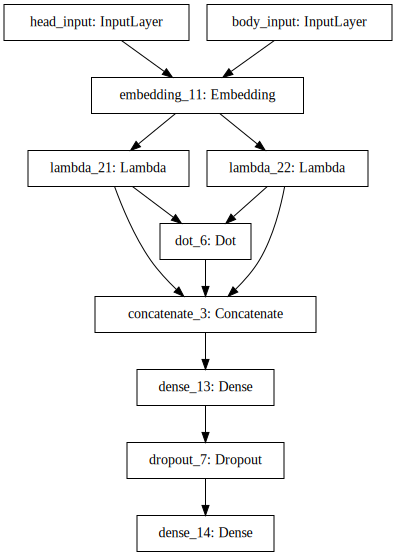

In [37]:
head_input = Input(shape=(max_head,), dtype='int32', name='head_input')
body_input = Input(shape=(max_body,), dtype='int32', name='body_input')
shared_embed = Embedding(len(word_index) + 1,EMBEDDING_DIM,weights=[embedding_matrix],trainable=False)
head_embed = shared_embed(head_input)
body_embed = shared_embed(body_input)
head_embed = Lambda(adder,output_shape=adder_output)(head_embed)
body_embed = Lambda(adder,output_shape=adder_output)(body_embed)
dot = dot([head_embed,body_embed],axes = 1, normalize=True)
conc = concatenate([head_embed,body_embed,dot])
dense = Dense(100,activation='relu')(conc)
dense = Dropout(0.33)(dense)
dense = Dense(4,activation='softmax')(dense)

model = Model(inputs=[head_input, body_input], outputs=[dense])
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
for i in range(5):
    model.fit([train_text,train_body],[y_train],validation_data = ([test_text,test_body],y_test),epochs=10, batch_size=64,verbose = True)
    evaluate_answer(model,[test_text,test_body],y_test)

Epoch 1/10
49972/49972 [==============================] - 10s 194us/step - loss: 0.3835 - acc: 0.8557
Epoch 2/10
49972/49972 [==============================] - 10s 192us/step - loss: 0.3686 - acc: 0.8629
Epoch 3/10
49972/49972 [==============================] - 11s 212us/step - loss: 0.3529 - acc: 0.8678
Epoch 4/10
49972/49972 [==============================] - 34s 686us/step - loss: 0.3377 - acc: 0.8749
Epoch 5/10
49972/49972 [==============================] - 11s 223us/step - loss: 0.3259 - acc: 0.8788
Epoch 6/10
49972/49972 [==============================] - 11s 226us/step - loss: 0.3107 - acc: 0.8849
Epoch 7/10
49972/49972 [==============================] - 11s 219us/step - loss: 0.3001 - acc: 0.8890
Epoch 8/10
49972/49972 [==============================] - 10s 209us/step - loss: 0.2911 - acc: 0.8943
Epoch 9/10
49972/49972 [==============================] - 10s 204us/step - loss: 0.2815 - acc: 0.8968
Epoch 10/10
49972/49972 [==============================] - 10s 202us/step - loss: 

In [38]:
for i in range(5):
    model.fit([train_text,train_body],[y_train],validation_data = ([test_text,test_body],y_test),epochs=5, batch_size=64,verbose = True)
    evaluate_answer(model,[test_text,test_body],y_test)

Train on 49972 samples, validate on 25413 samples
Epoch 1/5
49972/49972 [==============================] - 14s 278us/step - loss: 0.6864 - acc: 0.7629 - val_loss: 0.5043 - val_acc: 0.8275
Epoch 2/5
49972/49972 [==============================] - 14s 277us/step - loss: 0.4072 - acc: 0.8615 - val_loss: 0.4007 - val_acc: 0.8599
Epoch 3/5
49972/49972 [==============================] - 14s 279us/step - loss: 0.3469 - acc: 0.8810 - val_loss: 0.3878 - val_acc: 0.8636
Epoch 4/5
49972/49972 [==============================] - 14s 277us/step - loss: 0.3229 - acc: 0.8876 - val_loss: 0.3889 - val_acc: 0.8627
Epoch 5/5
49972/49972 [==============================] - 14s 278us/step - loss: 0.3093 - acc: 0.8923 - val_loss: 0.3839 - val_acc: 0.8622
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |   1082    |     0     |    594    |    227    |
------------

KeyboardInterrupt: 